In [1]:
from scipy.integrate import quad
from sympy import init_printing, latex
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
init_printing(latex_printer=lambda *args, **kwargs: latex(*args, mul_symbol='dot', **kwargs))

## Single Concentration versus Time Model

Key             Label                          Data      
SC              Surface Coverage               1         
r               Rate of Association            2         
P_capacity      Cell Capacity                  3         
S               Surface Area                   2         
V               Volume                         1         


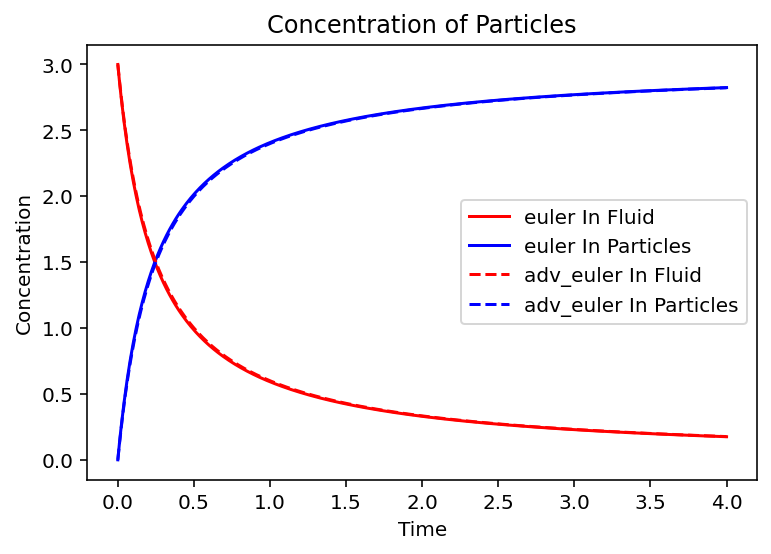

Cell Concentration p : 2.82352143019305


In [4]:


class ODE_Concentration:
    """Solve ODE using numerical iterations"""
    def __init__(self, STEP_SIZE, TARGET_TIME, INIT_U, INIT_P, params):
        self.STEP_SIZE = STEP_SIZE
        self.TARGET_TIME = TARGET_TIME
        self.INIT_U = INIT_U
        self.INIT_P = INIT_P
        self.params = params
        self.solve()

    ## Define Functions
    def f_cell_CCC(self, SC, r, P_capacity, p, u):
        return SC * r * (P_capacity-p)/P_capacity*u

    def du(self, S,V,f_cell):
        return -(S/V) * f_cell

    def dp(self, S,V,f_cell):
        return +(S/V) * f_cell

    def solve(self):
        ## Assign Values
        h = self.STEP_SIZE
        t = np.arange(0, self.TARGET_TIME+h, h)
        u = np.zeros(t.shape)
        p = np.zeros(t.shape)
        adv_u = np.zeros(t.shape)
        adv_p = np.zeros(t.shape)
        u[0] = self.INIT_U
        p[0] = self.INIT_P
        adv_u[0] = self.INIT_U
        adv_p[0] = self.INIT_P
        SC = self.params["SC"][1]
        r = self.params["r"][1]
        P_capacity = self.params["P_capacity"][1]
        S = self.params["S"][1]
        V = self.params["V"][1]

        ## Iterate and update
        for i in range( len(t) - 1 ):
            ## Normal Euler Method:  predict [NEXT point] using [CURRENT derivative]
            # Update U
            u[i+1] = u[i] + h * self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, p[i], u[i]))
            # Update P
            p[i+1] = p[i] + h * self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, p[i], u[i]))

            ## Advanced Euler Method: predict [NEXT point] using [CURRENT derrivarive]&[NEXT point's derivative]
            cur_du = self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i], adv_u[i]))
            cur_dp = self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i], adv_u[i]))

            pred_du = self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i] + h * cur_dp, adv_u[i] + h * cur_du))
            pred_dp = self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i] + h * cur_dp, adv_u[i] + h * cur_du))

            adv_u[i+1] = adv_u[i] + (h/2) * (cur_du + pred_du)
            adv_p[i+1] = adv_p[i] + (h/2) * (cur_dp + pred_dp)
        self.adv_u = adv_u
        self.adv_p = adv_p
        self.p = p
        self.u = u
        self.t = t

    def get_params(self):
        print("{:<15} {:<30} {:<10}".format('Key','Label','Data'))
        for k, v in self.params.items():
            label, data = v
            print("{:<15} {:<30} {:<10}".format(k, label, data))

    ## Plotting
    def plot_integral(self):
        self.get_params()
        fig = plt.figure(dpi = 144)
        ax = fig.gca()
        ax.plot(self.t, self.u, 'r-', label="euler In Fluid")
        ax.plot(self.t, self.p, 'b-', label="euler In Particles")
        ax.plot(self.t, self.adv_u, 'r--', label="adv_euler In Fluid")
        ax.plot(self.t, self.adv_p, 'b--', label="adv_euler In Particles")
        ax.set_ylabel("Concentration")
        ax.set_xlabel("Time")
        ax.set_title("Concentration of Particles")
        ax.legend(loc='center right')
        # plt.savefig("./1.jpg")
        plt.show()
        

    def get_fluid_concentration(self):
        return self.adv_u[-1]

    def get_cell_concentration(self):
        return self.adv_p[-1]

## Define Values
STEP_SIZE = 0.01
TARGET_TIME = 4
INIT_U = 3
INIT_P = 0
params = {   # Symbol + Description + Data
            "SC":["Surface Coverage", 1],
            "r":["Rate of Association", 2],
            "P_capacity":["Cell Capacity", 3],
            "S":["Surface Area", 2],
            "V":["Volume", 1],
        }

ode = ODE_Concentration(STEP_SIZE, TARGET_TIME, INIT_U, INIT_P, params)
ode.plot_integral()
print("Cell Concentration p :", ode.get_cell_concentration())


## Liver-Particle Association Model

In [5]:
  ## Define Stuctures
class Particle:
    def __init__(self, type, size, ):
        self.type=type
        self.size = size
        
    def get_type(self):
        print(self.type)

class Cell:
    def __init__(self, r_in, r_out, max_capacity, init_concentration):
        self.r_in = r_in
        self.r_out = r_out
        self.capacity = max_capacity
        self.concentration = init_concentration
        self.u = []

class fluid:
    def __init__(self, r, init_concentration):
        self.r = r
        self.concentration = init_concentration
        self.u = []

In [9]:


class ODE_Liver_Particle:
    """Solve ODE using numerical iterations"""
    def __init__(self, STEP_SIZE, TARGET_TIME, Particle, Blood, Kupffer, Endothelial, Space, Hepatocytes, BileDuct):
        self.P = Particle
        self.STEP_SIZE = STEP_SIZE
        self.TARGET_TIME = TARGET_TIME
        self.Particle = Particle
        self.Blood = Blood
        self.Kupffer = Kupffer
        self.Endothelial = Endothelial
        self.Space = Space
        self.Hepatocytes = Hepatocytes
        self.BileDuct = BileDuct


    ## Define Functions

    def f_f2c(self, Fluid, Cell):
        """Fluid to Cell Generalised Function"""
        return self.SC * Cell.r_in * ((Cell.capacity - self.concentration)/Cell.capacity) * Fluid.concentration

    def f_c2f(self, Fluid, Cell):
        """Cell to Fluid Generalised Function"""
        return self.SC * Cell.r_out * Cell.concentration

    def f_f2f(self, FluidA, FluidB):
        """FluidA to FluidB Generalised Function"""
        return FluidA.r * FluidB.r * 1/self.P.size * FluidA.concentration


    # Differential Equation
    def dBlood(self):
        return self.f_c2f(self.Kupffer, self.Blood) - self.f_f2c(self.Blood, self.Kupffer) + self.f_c2f(self.Endothelial, Blood)\
            + self.f_f2f(self.Space, self.Blood) - self.f_f2f(self.Blood, self.Space)

    def dKupffer(self):
        return self.f_f2c(self.Blood, self.Kupffer) + self.f_c2f(self.Kupffer, self.Blood)

    def dEndothelial(self):
        return self.f_f2c(self.Blood, self.Endothelial) - self.f_c2f(self.Endothelial, self.Blood)\
            + self.f_f2c(self.Space, self.Endothelial) - self.f_c2f(self.Endothelial, self.Space)
    
    def dSpace(self):
        return self.f_f2f(self.Blood, self.Space) - self.f_f2f(self.Blood, self.Space) + self.f_c2f(self.Endothelial, self.Space)\
            - self.f_f2c(self.Space, self.Endothelial)

    def dHepatocytes(self):
        return self.f_f2c(self.Space, self.Hepatocytes)

    def dBileDuct(self):
        return self.f_c2f(self.Hepatocytes, self.BileDuct)


    def set_init(self, t):
        """Set Initial Value and initialize array for use"""
        self.Particle.u = np.zeros(t.shape)
        self.Blood.u = np.zeros(t.shape)
        self.Kupffer.u = np.zeros(t.shape)
        self.Endothelial.u = np.zeros(t.shape)
        self.Space.u = np.zeros(t.shape)
        self.BileDuct.u = np.zeros(t.shape)

    def update_concentration(self, i):
        """update the Concentration to newest data"""
        self.Particle.concentration = self.Particle.u[i] 
        self.Blood.concentration = self.Blood.u[i]
        self.Kupffer.concentration = self.Kupffer.u[i]
        self.Endothelial.concentration = self.Endothelial.u[i]
        self.Space.concentration = self.Space.u[i]
        self.BileDuct.concentration = self.BileDuct.u[i]

    def solve(self):
        """Solve the ODE with given conditions"""
        ## Assign Values and set initial value
        h = self.STEP_SIZE
        t = np.arange(0, self.TARGET_TIME+h, h)
        self.set_init(t)

        ## Iterate and update
        for i in range( len(t) - 1 ):
            ## Normal Euler Method:  predict [NEXT point] using [CURRENT derivative]
            self.Blood.u[i+1] = self.Blood.u[i] + h * self.dBlood()
            self.Kupffer.u[i+1] = self.Kupffer.u[i] + h * self.dKupffer()
            self.Endothelial.u[i+1] = self.Endothelial.u[i] + h * self.dEndothelial()
            self.Space.u[i+1] = self.Space.u[i] + h * self.dSpace()
            self.BileDuct.u[i+1] = self.BileDuct.u[i] + h * self.dBileDuct()

            ## Update Concentration to newest ones.
            ## Advanced Euler Method: predict [NEXT point] using [CURRENT derrivarive]&[NEXT point's derivative]
            # Skipped, as the results should roughly be the same if the step size is small enough

    def get_params(self):
        print("{:<15} {:<30} {:<10}".format('Key','Label','Data'))
        for k, v in self.params.items():
            label, data = v
            print("{:<15} {:<30} {:<10}".format(k, label, data))

    ## Plotting
    def plot_integral(self):
        self.get_params()
        fig = plt.figure(dpi = 144)
        ax = fig.gca()
        ax.plot(self.t, self.Blood.u, 'r-', label="Blood")
        ax.plot(self.t, self.Kupffer.u, 'g-', label="Kupffer")
        ax.plot(self.t, self.Endothelial.u, 'b-', label="Endothelial")
        ax.plot(self.t, self.Space.u, 'y-', label="Space")
        ax.plot(self.t, self.BileDuct.u, 'm-', label="BileDuct")
        ax.set_ylabel("Concentration")
        ax.set_xlabel("Time")
        ax.set_title("Concentration of Particles")
        ax.legend(loc='center right')
        # plt.savefig("./1.jpg")
        plt.show()
        




    def get_fluid_concentration(self):
        return self.adv_u[-1]

    def get_cell_concentration(self):
        return self.adv_p[-1]




In [ ]:
## Define Values
STEP_SIZE = 0.01
TARGET_TIME = 4
params = {   # Symbol + Description + Data
            "SC":["Surface Coverage", 1],
            "r":["Rate of Association", 2],
            "P_capacity":["Cell Capacity", 3],
            "S":["Surface Area", 2],
            "V":["Volume", 1],
        }
#Params: STEP_SIZE, TARGET_TIME, Particle, Blood, Kupffer, Endothelial, Space, Hepatocytes, BileDuct
ode = ODE_Liver_Particle(STEP_SIZE, TARGET_TIME, INIT_U, INIT_P, params)
ode.plot_integral()
print("Cell Concentration p :", ode.get_cell_concentration())

## Liver-Particle Association Model